In [16]:
import os
import sys
sys.path.insert(0, os.path.dirname(os.getcwd()))
import time
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold
from PALM.utils import Func_D, Generate_data_disc, Assoc_SNPs, Perf, get_nn_var_imp

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

## Implementation of PALM-NN with ground true association status
so that we can monitor the change of FDR and power along the model fitting process

In [10]:
# 3-layer MLP
class NN(nn.Module):
    def __init__(self, D, d, p=0):
        super(NN, self).__init__()
        self.fc1 = nn.Linear(D, d)
        self.fc2 = nn.Linear(d, 2)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [19]:
def EM_NN(net, optimizer, criterion, pvals_train, A_train, pvals_eval=None, A_eval=None,
          alpha=0.4, max_iter=1000, print_every=100, verbose=True,
          Z=None, Z_eval=None, opt_iter=None):
    
    '''
    EM-path algorithm with neural network.
    
    :param net: neural network, torch.nn.Module
    :param optimizer: optimizer, torch.nn.optim
    :param criterion: loss function, torch.nn.CrossEntropyLoss
    :param pvals_train: training p-values of snps, np.ndarray (M_train,)
    :param A_train: training annotation matrix, np.ndarray (M_train, D)
    :param pvals_eval: evaluation p-values of snps, np.ndarray (M_eval,)
    :param A_eval: evaluation annotation matrix, np.ndarray (M_eval, D)
    :param alpha: initial alpha (parameter of beta distribution)
    :param max_iter: maximum number of iterations
    :param print_every: print frequency
    :param verbose: verbose or not
    :param Z: training ground truth latent status, np.ndarray (M_train,)
    :param Z_eval: evaluation ground truth latent status np.ndarray (M_eval,)
    :param opt_iter: best number of iterations selected by cross-validation
    :return: a dictionary containing estimated parameters, likelihood (and trained network)
    '''

    # Data size
    M_train = len(pvals_train)
    
    # Clamp pvals
    pvals_train = torch.clamp(pvals_train, 1e-16, 1 - 1e-16)
    if pvals_eval is not None:
        pvals_eval = torch.clamp(pvals_eval, 1e-16, 1 - 1e-16)

    # Record parameters
    Lq_evals, loss_evals = [], []
    if pvals_eval is not None and A_eval is not None:
        M_eval = len(pvals_eval)
        rec = np.zeros((max_iter, 4))
    else:
        rec = np.zeros((max_iter, 3))
    rec[:, 0] = np.arange(max_iter)
    
    # Record performance along the training process if ground truth is available
    if Z is not None:
        FDRs, powers, pAUCs, AUCs = [], [], [], []
    if Z_eval is not None:
        FDRs_eval, powers_eval, pAUCs_eval, AUCs_eval = [], [], [], []


    for i in range(max_iter):

        net.train()
        FA_train = net(A_train)

        with torch.no_grad():
            
            # Evaluate
            if pvals_eval is not None and A_eval is not None:
                net.eval()
                FA_eval = net(A_eval)
                pi = FA_eval.softmax(1)  # (M_train, 2): (pi0, pi1)
                pi0, pi1 = pi[:, 0], pi[:, 1]
                comp1 = pi1 * alpha * pvals_eval ** (alpha - 1)
                z1 = comp1 / (comp1 + pi0)
                Lq_eval = torch.sum(torch.log(pi1 * alpha * pvals_eval ** (alpha - 1) + pi0))
                Lq_eval = Lq_eval.item() / M_eval
                Lq_evals.append(Lq_eval)
                label = torch.vstack((1 - z1, z1)).transpose(0, 1)
                loss_eval = criterion(FA_eval[pvals_eval > 0], label[pvals_eval > 0])
                loss_evals.append(loss_eval)
                rec[i, 3] = Lq_eval
                
                # Identify snps and evaluate performance on testing data
                if Z_eval is not None:
                    if z1.device is not 'cpu':
                        post = z1.detach().cpu().numpy()
                    else:
                        post = z1.numpy()
                    est_Z = Assoc_SNPs(post, fdrcontrol='global')
                    nn_perf = Perf(Z_eval, est_Z, 1 - post)
                    FDRs_eval.append(nn_perf['FDR'])
                    powers_eval.append(nn_perf['power'])
                    pAUCs_eval.append(nn_perf['pAUC'])
                    AUCs_eval.append(nn_perf['AUC'])


            # E step
            pi = FA_train.softmax(1)  # (M_train, 2): (pi0, pi1)
            pi0, pi1 = pi[:, 0], pi[:, 1]
            comp1 = pi1 * alpha * pvals_train ** (alpha - 1)
            z1 = comp1 / (comp1 + pi0)
            Lq = torch.sum(torch.log(pi1 * alpha * pvals_train ** (alpha - 1) + pi0))
            Lq = Lq.item() / M_train

            # Identify snps and evaluate performance on training data
            if Z is not None:
                if z1.device is not 'cpu':
                    post = z1.detach().cpu().numpy()
                else:
                    post = z1.numpy()
                est_Z = Assoc_SNPs(post, fdrcontrol='global')
                nn_perf = Perf(Z, est_Z, 1 - post)
                FDRs.append(nn_perf['FDR'])
                powers.append(nn_perf['power'])
                pAUCs.append(nn_perf['pAUC'])
                AUCs.append(nn_perf['AUC'])
            if opt_iter is not None and i == opt_iter:
                opt_net = net
                if z1.device is not 'cpu':
                    opt_post = z1.detach().cpu().numpy()
                else:
                    opt_post = z1.numpy()

            # M step
            alpha = (- torch.sum(z1[pvals_train > 0]) / torch.dot(z1[pvals_train > 0],
                                                                  torch.log(pvals_train[pvals_train > 0]))).item()

        # Update network parameters
        optimizer.zero_grad()
        label = torch.vstack((1 - z1, z1)).transpose(0, 1) # pred: FA (M, 2), label: (M, 2)
        loss = criterion(FA_train[pvals_train > 0], label[pvals_train > 0])
        loss.backward()
        optimizer.step()

        # Record
        rec[i, 1] = alpha
        rec[i, 2] = Lq

        # Verbose
        if verbose and i > 0 and (i % print_every == 0 or i == 1):
            if pvals_eval is not None and A_eval is not None:
                print(f'Iteration: {i:>5d}, Loss: {loss.item():8.6f}, Loss_eval: {loss_eval.item():8.6f}, Lq: {Lq:12.8f}, Lq_eval: {Lq_eval:12.8f}, alpha: {alpha:7.5f}')
            else:
                print(f'Iteration: {i:5d}, Loss: {loss.item():8.6f}, Lq: {Lq:12.8f}, alpha: {alpha:7.5f}')
            if Z is not None:
                print(f' - FDR: {FDRs[i]:5.4f}, power: {powers[i]:5.4f}, pAUC: {pAUCs[i]:5.4f}, AUC: {AUCs[i]:5.4f}')
            if Z_eval is not None:
                print(f' - FDR_eval: {FDRs_eval[i]:5.4f}, power_eval: {powers_eval[i]:5.4f}, pAUC_eval: {pAUCs_eval[i]:5.4f}, AUC_eval: {AUCs_eval[i]:5.4f}')

    # Return
    if pvals_eval is not None and A_eval is not None:
        ret = {'post': z1.detach().cpu().numpy(), 'Lq': rec[:, 2], 'Lq_eval': rec[:, 3], 'alpha': rec[:, 1]}
    else:
        ret = {'post': z1.detach().cpu().numpy(), 'Lq': rec[:, 2], 'alpha': rec[:, 1]}

    if Z is not None:
        ret['FDR'] = FDRs; ret['power'] = powers; ret['pAUC'] = pAUCs; ret['AUC'] = AUCs
    if Z_eval is not None:
        ret['FDR_eval'] = FDRs_eval; ret['power_eval'] = powers_eval; ret['pAUC_eval'] = pAUCs_eval; ret['AUC_eval'] = AUCs_eval

    if opt_iter is not None:
        ret['post'] = opt_post
        return ret, opt_net
    else:
        return ret

## A small simulation

In [11]:
# Setting
M = 20000 # number of SNPs
D = 50 # number of annotations
K = 5 # CV fold
Func_name = 'Func_D' # function F
Func = eval(Func_name)

# Generate data
zs, pvals, A, Z = Generate_data_disc(M, D, Func)

In [12]:
device = 'cuda:4'
d = 100 # hidden dim
p = 0 # no dropout
lr = 0.001 # learning rate
w = 0.001 # weight decay
max_iter = 1000
print_every = 100
verbose = False
# convert numpy to tensor
pvals, A = torch.Tensor(pvals), torch.Tensor(A)

In [17]:
# CV
t0 = time.time()

idx = np.arange(M)
kf = KFold(n_splits=K)
cv_Lqs = np.zeros((max_iter, K))
cv_FDRs, cv_powers = np.zeros((max_iter, K)), np.zeros((max_iter, K))
cv_dict = dict.fromkeys(np.arange(1, K))
for k, (train, test) in enumerate(kf.split(idx)):

    pvals_train, A_train, pvals_eval, A_eval = \
        pvals[train].to(device), A[train].to(device), pvals[test].to(device), A[test].to(device)

    Z_train, Z_eval = Z[train], Z[test]
    if not isinstance(Z, np.ndarray):
        Z_train, Z_eval = Z_train.numpy(), Z_eval.numpy()

    net = NN(D, d, p).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(net.parameters(), lr=lr, weight_decay=w)

    alpha = 0.4
    t1 = time.time()
    ret = EM_NN(net, optimizer, criterion, pvals_train, A_train, pvals_eval=pvals_eval, A_eval=A_eval,
          alpha=alpha, max_iter=max_iter, print_every=100, verbose=verbose,
          Z=None, Z_eval=Z_eval, opt_iter=None)
    ret['time'] = time.time() - t1

    cv_Lqs[:, k] = ret['Lq_eval']
    cv_FDRs[:, k], cv_powers[:, k] = ret['FDR_eval'], ret['power_eval']
    cv_dict[k] = ret
    print(f"----------- Finish fold {k} | M{M}-D{D}: d{d}-p{p}-lr{lr}-w{w} -----------")
print(f'CV time: {time.time() - t0:8.3f}s')

----------- Finish fold 0 | M20000-D50: d100-p0-lr0.001-w0.001 -----------
----------- Finish fold 1 | M20000-D50: d100-p0-lr0.001-w0.001 -----------
----------- Finish fold 2 | M20000-D50: d100-p0-lr0.001-w0.001 -----------
----------- Finish fold 3 | M20000-D50: d100-p0-lr0.001-w0.001 -----------
----------- Finish fold 4 | M20000-D50: d100-p0-lr0.001-w0.001 -----------
CV time:   81.506s


In [20]:
# (K+1)-th model
t1 = time.time()

alpha = 0.4
cv_Lq = np.mean(cv_Lqs, axis=1)
cv_opt_Lq = np.argmax(cv_Lq[1:]) + 1

pvals, A = pvals.to(device), A.to(device)
if not isinstance(Z, np.ndarray):
    Z = Z.numpy()
net = NN(D, d, p).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=lr, weight_decay=w)

ret_opt, net_opt = EM_NN(net, optimizer, criterion, pvals, A, pvals_eval=None, A_eval=None,
                         alpha=alpha, max_iter=max_iter, print_every=print_every, verbose=True,
                         Z=Z, Z_eval=None, opt_iter=cv_opt_Lq)
ret_opt['time'] = time.time() - t1
print(f'(K+1)-th model time: {time.time() - t1:8.3f}s')

Iteration:     1, Loss: 0.690550, Lq:   0.21866636, alpha: 0.40070
 - FDR: 0.2385, power: 0.4994, pAUC: 0.7648, AUC: 0.8170
Iteration:   100, Loss: 0.526046, Lq:   0.25957559, alpha: 0.25324
 - FDR: 0.1090, power: 0.4007, pAUC: 0.7854, AUC: 0.8540
Iteration:   200, Loss: 0.432147, Lq:   0.29906792, alpha: 0.24206
 - FDR: 0.0991, power: 0.4881, pAUC: 0.8391, AUC: 0.9155
Iteration:   300, Loss: 0.369964, Lq:   0.32226147, alpha: 0.23627
 - FDR: 0.1116, power: 0.5467, pAUC: 0.8595, AUC: 0.9319
Iteration:   400, Loss: 0.332056, Lq:   0.33512324, alpha: 0.23270
 - FDR: 0.1230, power: 0.5830, pAUC: 0.8658, AUC: 0.9358
Iteration:   500, Loss: 0.311623, Lq:   0.34219023, alpha: 0.23047
 - FDR: 0.1267, power: 0.6035, pAUC: 0.8668, AUC: 0.9359
Iteration:   600, Loss: 0.299145, Lq:   0.34681885, alpha: 0.22908
 - FDR: 0.1324, power: 0.6136, pAUC: 0.8659, AUC: 0.9351
Iteration:   700, Loss: 0.290486, Lq:   0.35008325, alpha: 0.22820
 - FDR: 0.1372, power: 0.6211, pAUC: 0.8649, AUC: 0.9342
Iteratio

## Results

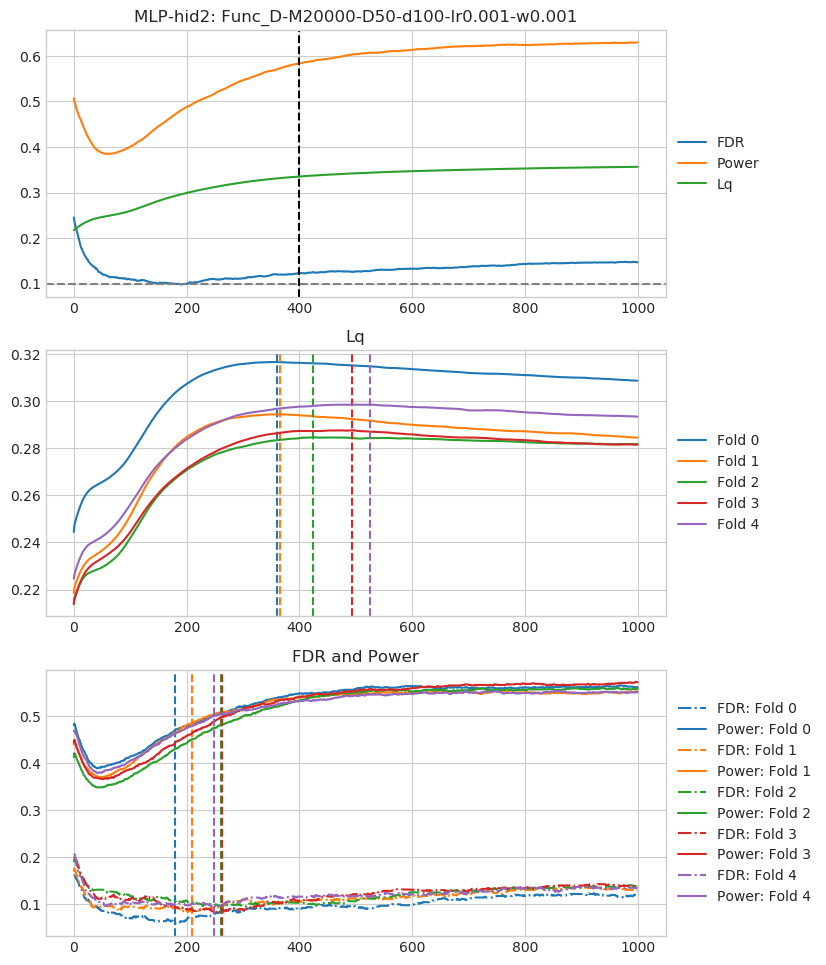

In [21]:
# Change of FDR and power over iterations
plt.style.use('seaborn-whitegrid')
fig, axes = plt.subplots(3, 1, figsize=(8, 12), dpi=100)
x = np.arange(len(ret_opt['FDR']))
axes[0].plot(x, ret_opt['FDR'], color='C0', linewidth=1.5, label='FDR')
axes[0].plot(x, ret_opt['power'], color='C1', linewidth=1.5, label='Power')
axes[0].plot(x, ret_opt['Lq'], color='C2', linewidth=1.5, label='Lq')
axes[0].axhline(y=0.1, color='gray', linestyle='--')
axes[0].axvline(x=cv_opt_Lq, color='black', linestyle='--')
axes[0].legend(loc='center left', bbox_to_anchor=(1, 0.5), fancybox=True)
axes[0].set_title(f'MLP-hid2: {Func_name}-M{M}-D{D}-d{d}-lr{lr}-w{w}')
x = np.arange(cv_Lqs.shape[0])
for i in range(K):
    axes[1].plot(x, cv_Lqs[:, i], linewidth=1.5, label=f'Fold {i}', color=f'C{i}')
    axes[1].axvline(x=np.argmax(cv_Lqs[1:, i]), color=f'C{i}', linestyle='--')
    axes[1].legend(loc='center left', bbox_to_anchor=(1, 0.5), fancybox=True)
    axes[1].set_title(f'Lq')
    axes[2].plot(x, cv_FDRs[:, i], linewidth=1.5, linestyle='dashdot', label=f'FDR: Fold {i}', color=f'C{i}')
    axes[2].plot(x, cv_powers[:, i], linewidth=1.5, linestyle='-', label=f'Power: Fold {i}', color=f'C{i}')
    axes[2].axvline(x=np.argmin(cv_FDRs[1:, i]), color=f'C{i}', linestyle='--')
    axes[2].legend(loc='center left', bbox_to_anchor=(1, 0.5), fancybox=True)
    axes[2].set_title(f'FDR and Power')
plt.show()

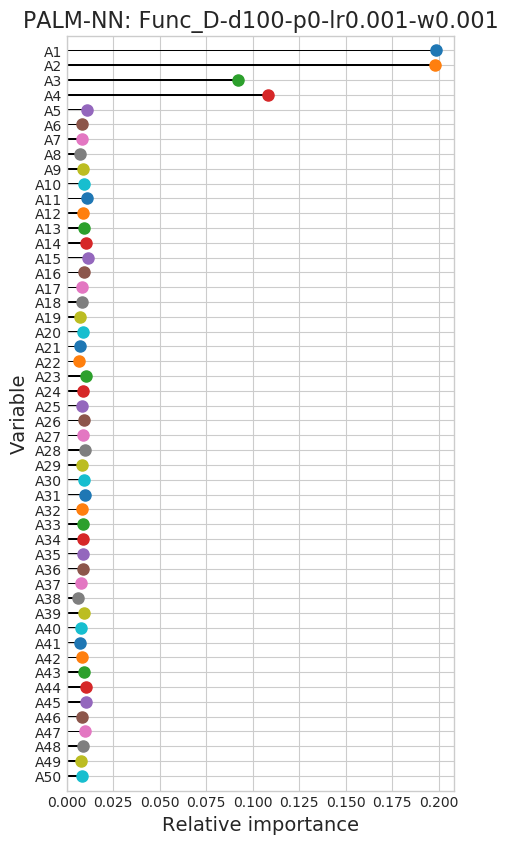

In [22]:
# Variable importance
alpha = torch.tensor(ret_opt['alpha'][-1]).to(device)
var_imp = get_nn_var_imp(net, pvals, A, alpha)
D = len(var_imp)
plt.style.use('seaborn-whitegrid')
fig, ax = plt.subplots(figsize=(5, 10), dpi=100)
ax.set_prop_cycle('color', plt.cm.tab10.colors)
for i in range(len(var_imp)):
    ax.plot(var_imp[i], i, 'o', ms=8)
ax.barh(np.arange(len(var_imp)), var_imp, align='center', color='black', height=0.1)
ax.tick_params(axis='y', which='major', labelsize=10)
ax.tick_params(axis='y', which='minor', labelsize=10)
ax.set_yticks(np.arange(len(var_imp)))
ax.set_yticklabels([f'A{i + 1}' for i in range(len(var_imp))])
ax.set_ylim(-1, D)
ax.invert_yaxis()
ax.set_xlabel('Relative importance', fontsize=14)
ax.set_ylabel('Variable', fontsize=14)
ax.set_title(f'PALM-NN: {Func_name}-d{d}-p{p}-lr{lr}-w{w}', fontsize=16)
plt.show()